## &#x1F310; &nbsp; Code Library, Style, and Links

In [529]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}               
</style>

In [530]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from descartes import PolygonPatch

from IPython.display import HTML

In [531]:
style_dict = {'background-color':'slategray',
              'color':'#37c9e1'}
# df.style.set_properties(**style_dict)

## &#x1F310; &nbsp; Load and Preprocess the Data

In [532]:
school_explorer = pd.read_csv('2016 School Explorer.csv')
d5_shsat = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
school_explorer.shape, d5_shsat.shape

((1272, 161), (140, 7))

In [533]:
d5_shsat.head().style.set_properties(**style_dict)

,DBN,School name,Year of SHST,Grade level,Enrollment on 10/31,Number of students who registered for the SHSAT,Number of students who took the SHSAT
0,05M046,P.S. 046 Arthur Tappan,2013,8,91,31,14
1,05M046,P.S. 046 Arthur Tappan,2014,8,95,26,7
2,05M046,P.S. 046 Arthur Tappan,2015,8,73,21,10
3,05M046,P.S. 046 Arthur Tappan,2016,8,56,20,8
4,05M123,P.S. 123 Mahalia Jackson,2013,8,62,31,14


In [534]:
# Fillna or replace values
numeric_list = list(school_explorer\
.columns[[7,8]+list(range(16,27))+[28,30,32,34,36]+list(range(42,161))])
target_list = ['Average ELA Proficiency','Average Math Proficiency']

school_explorer = school_explorer.drop(['Adjusted Grade',
                                        'New?',
                                        'Other Location Code in LCGMS'], 
                                       axis=1)
school_explorer.loc[[427,1023,712,908],'School Name'] = \
['P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27']

percent_list = ['Percent ELL','Percent Asian','Percent Black',
                'Percent Hispanic','Percent Black / Hispanic',
                'Percent White','Student Attendance Rate',
                'Percent of Students Chronically Absent',
                'Rigorous Instruction %','Collaborative Teachers %',
                'Supportive Environment %','Effective School Leadership %',
                'Strong Family-Community Ties %','Trust %']

for el in percent_list:
    school_explorer[el] = school_explorer[el].astype('str')
    school_explorer[el] = school_explorer[el].str.replace("%", "")
    school_explorer[el] = school_explorer[el].str.replace("nan", "0")
    school_explorer[el] = school_explorer[el].astype(float)
    school_explorer[el].replace(0, np.NaN, inplace=True)
    school_explorer[el] = school_explorer[el].interpolate()
    
school_explorer['Economic Need Index'] = \
school_explorer['Economic Need Index'].interpolate()
school_explorer['Average ELA Proficiency'] = \
school_explorer['Average ELA Proficiency'].interpolate()
school_explorer['Average Math Proficiency'] = \
school_explorer['Average Math Proficiency'].interpolate()

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype('str') 
for s in [",","$"," "]:
    school_explorer['School Income Estimate'] = \
    school_explorer['School Income Estimate'].str.replace(s, "")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].str.replace("nan", "0")

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype(float)
school_explorer['School Income Estimate'].replace(0, np.NaN, inplace=True)
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].interpolate()

rating_list = ['Rigorous Instruction Rating','Collaborative Teachers Rating',
               'Supportive Environment Rating','Effective School Leadership Rating',
               'Strong Family-Community Ties Rating','Strong Family-Community Ties Rating',
               'Trust Rating','Student Achievement Rating']

for el in rating_list:
    moda_value = school_explorer[el].value_counts().idxmax()
    school_explorer[el] = school_explorer[el].fillna(moda_value) 
    
category_list1 = ['District','Community School?','City','Grades']
                  
category_list2 = ['Rigorous Instruction Rating',
                  'Collaborative Teachers Rating',
                  'Supportive Environment Rating',
                  'Effective School Leadership Rating',
                  'Strong Family-Community Ties Rating',
                  'Trust Rating','Student Achievement Rating']

for feature in category_list1:
    feature_cat = pd.factorize(school_explorer[feature])
    school_explorer[feature] = feature_cat[0]
    
for feature in category_list2:
    feature_pairs = dict(zip(['Not Meeting Target', 'Meeting Target', 
                              'Approaching Target', 'Exceeding Target'],
                             ['0','2','1','3']))
    school_explorer[feature].replace(feature_pairs,inplace=True)
    school_explorer[feature] = school_explorer[feature].astype(int)
    
category_list = list(category_list1+category_list2)
    
print('NaN count = ', sum(school_explorer.isna().sum()))    

NaN count =  0


In [535]:
d5_shsat_2016 = d5_shsat[['DBN','Number of students who registered for the SHSAT',
                          'Number of students who took the SHSAT']][d5_shsat['Year of SHST']==2016]\
.groupby(['DBN'],as_index=False).agg(np.sum)

d5_shsat_2016['Took SHSAT %'] = d5_shsat_2016['Number of students who took the SHSAT']\
/d5_shsat_2016['Number of students who registered for the SHSAT']

d5_shsat_2016['Took SHSAT %'] = d5_shsat_2016['Took SHSAT %'].fillna(0).apply(lambda x: round(x,3))
d5_shsat_2016.rename(columns={'DBN':'Location Code'}, inplace=True)

d5_shsat_2016 = pd.merge(school_explorer[['Location Code']+numeric_list+target_list],
                         d5_shsat_2016, 
                         on='Location Code')
d5_shsat_2016.shape

(21, 143)

In [536]:
geo_districts = gpd.GeoDataFrame.from_file("nysd.shp") # EPSG:2263
geo_districts = geo_districts.to_crs(epsg=4326).sort_values('SchoolDist')

geo_districts = geo_districts.reset_index(drop=True)

districts = school_explorer[numeric_list+['Average ELA Proficiency','Average Math Proficiency']]\
.groupby(school_explorer['District']).mean().sort_values('District')
districts = districts.append(districts.loc[9]).sort_values('District')
districts = districts.reset_index(drop=True)
districts = pd.concat([geo_districts, districts], axis=1)

## &#x1F310; &nbsp; Educational Data Visualization

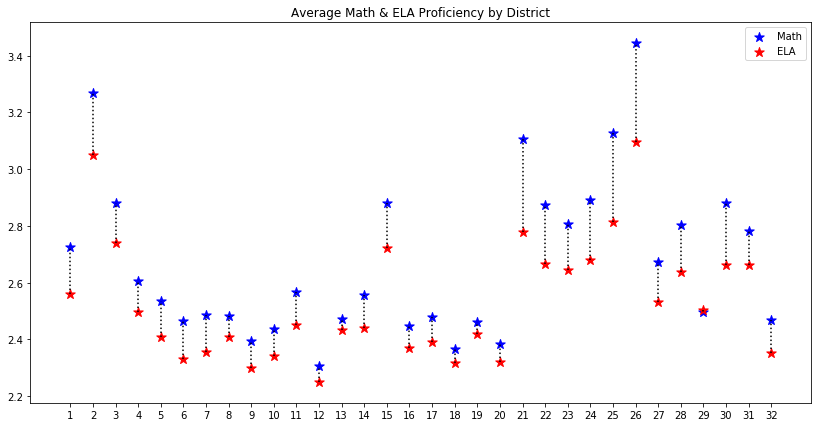

In [537]:
fig,ax = plt.subplots(1, figsize=(14,7))
avg_maths = districts['Average Math Proficiency'].drop([10])
avg_ela = districts['Average ELA Proficiency'].drop([10])

ax.scatter(range(1,33),avg_maths,marker='*',s=100,label='Math',c='b')
ax.scatter(range(1,33),avg_ela,marker='*',s=100,label='ELA',c='r')
plt.vlines(range(1,33),avg_ela,avg_maths,linestyle="dotted")
ax.legend()
ax.set_xticks(list(range(1,33)))
plt.title('Average Math & ELA Proficiency by District');

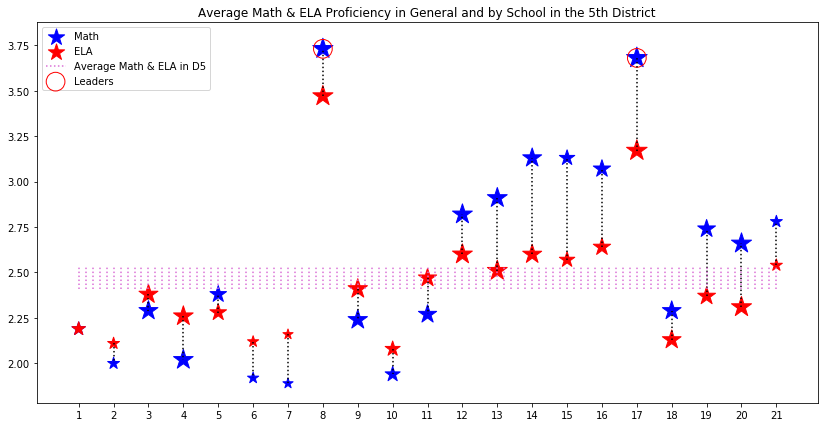

In [538]:
fig,ax = plt.subplots(1, figsize=(14,7))
avg_maths2 = d5_shsat_2016['Average Math Proficiency']
avg_ela2 = d5_shsat_2016['Average ELA Proficiency']
took = d5_shsat_2016['Took SHSAT %']

ax.scatter(range(1,22),avg_maths2,marker='*',s=took*500,label='Math',c='b')
ax.scatter(range(1,22),avg_ela2,marker='*',s=took*500,label='ELA',c='r')
plt.vlines(range(1,22),avg_ela2,avg_maths2,linestyle="dotted")
plt.vlines(np.arange(1.0,21.2,0.2),avg_ela[4],avg_maths[4],
           colors='orchid',linestyle="dotted",
           label='Average Math & ELA in D5')

ax.scatter([8,17],avg_maths2[[7,16]],label='Leaders',
           s=350,facecolors='none',edgecolors='r')
ax.legend(loc=2)
ax.set_xticks(list(range(1,22)))
plt.title('Average Math & ELA Proficiency in General and by School in the 5th District');

On this graph, we can see two absolute leaders in educational results. 

The size of the marker on the graph corresponds to the ratio of students who took the SHSAT to those who registered for the SHSAT.

These leaders have very good results in this ratio too.

## &#x1F310; &nbsp; Economic Indicator Visualization

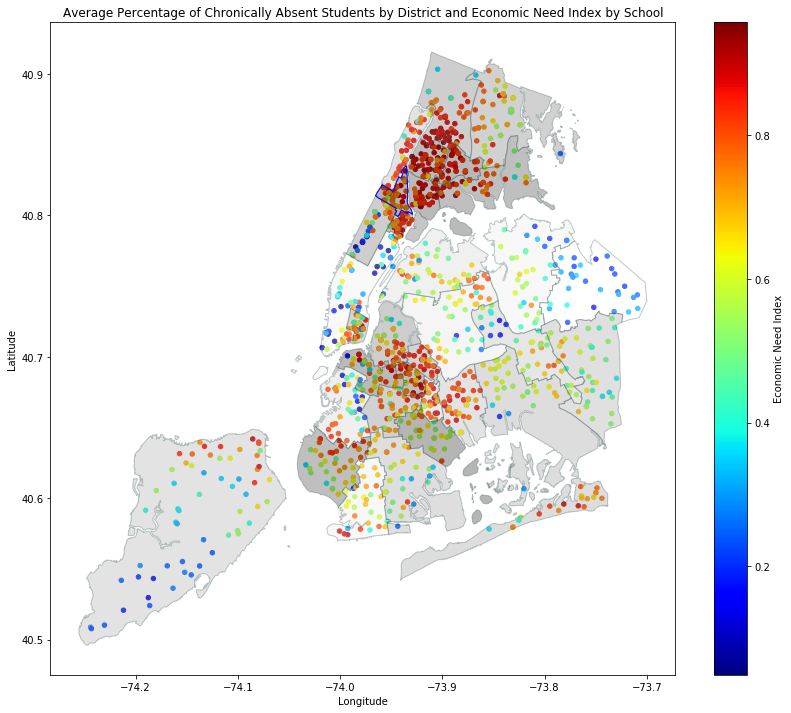

In [539]:
fig,ax = plt.subplots(1, figsize=(14,12))
school_explorer.plot(kind='scatter',x='Longitude',y='Latitude',ax=ax,
                     s=20,c='Economic Need Index',cmap=cm.jet)
ax.add_patch(PolygonPatch(districts.geometry[4], fc='none', ec='b', zorder=2 ))
districts.plot(ax=ax, column='Percent of Students Chronically Absent', 
               cmap='Greys', alpha=0.3, edgecolor='darkslategray')
plt.title('Average Percentage of Chronically Absent Students by District \
and Economic Need Index by School');

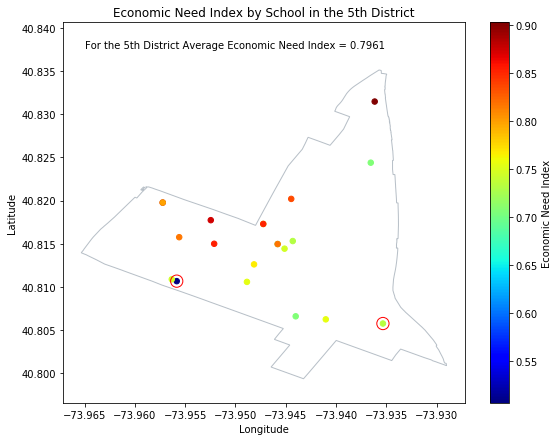

In [540]:
fig = plt.figure(figsize=(9,7)) 
ax = fig.gca() 
ax.add_patch(PolygonPatch(districts.geometry[4],
                          fc='none',ec='slategray', 
                          alpha=0.5,zorder=2 ))
d5_shsat_2016.plot(kind='scatter',x='Longitude',y='Latitude',ax=ax,
                   s=30,c='Economic Need Index',cmap=cm.jet)
ax.scatter(d5_shsat_2016['Longitude'][[7,16]],
           d5_shsat_2016['Latitude'][[7,16]],
           s=150,facecolors='none',edgecolors='r')
ax.text(-73.965,40.8377,
        'For the 5th District Average Economic Need Index = '+\
        str(round(districts['Economic Need Index'][4],4)))
plt.title('Economic Need Index by School in the 5th District');

Two leaders among schools in the 5th District have the certain difference in the economic situation.